In [2]:
# format cells using black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# multilingual models

In [2]:
cwd = os.getcwd()
models = {
    "distiluse-base-multilingual-cased-v1":0,
    "paraphrase-multilingual-MiniLM-L12-v2":0,
    "paraphrase-multilingual-mpnet-base-v2":0,
}

for model in models:
    temp_path = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(temp_path, "rb") as f:
        temp_data = pickle.load(f)
        models[model]=len(temp_data[model][0])
        
for k,v in models.items():
    print(f'{v} | ({k})')
    
print("\n")
m = np.mean(list(models.values()))
p = round(((m/20457)*100),4)
print(f'mean progress: {int(m)} / 20457 ({p}%)')

20457 | (distiluse-base-multilingual-cased-v1)
20457 | (paraphrase-multilingual-MiniLM-L12-v2)
20457 | (paraphrase-multilingual-mpnet-base-v2)


mean progress: 20457 / 20457 (100.0%)


# (1) model: distiluse-base-multilingual-cased-v1

## ndb <- wikipedia

### mean

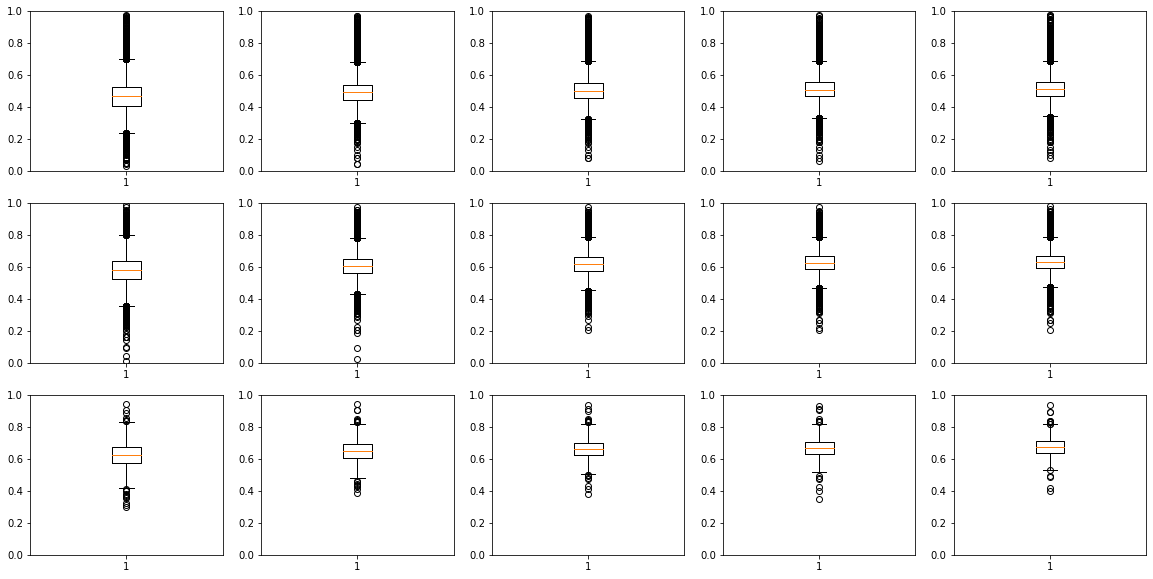

<IPython.core.display.Javascript object>

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(20,10))

for idx,model in enumerate(models):
    p = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(p, "rb") as f:
        d = pickle.load(f)
        for i, v in enumerate(d[model]):
            mean_vals = []
            for k,t in v.items():
                if t[0]:
                    mean_vals.append(np.mean(t[0]))
            ax[idx,i].boxplot(mean_vals)
            #ax[idx,i].axhline(y=np.median(mean_vals), color='orange',linewidth=1)
plt.setp(ax, ylim=(0,1))
plt.show()

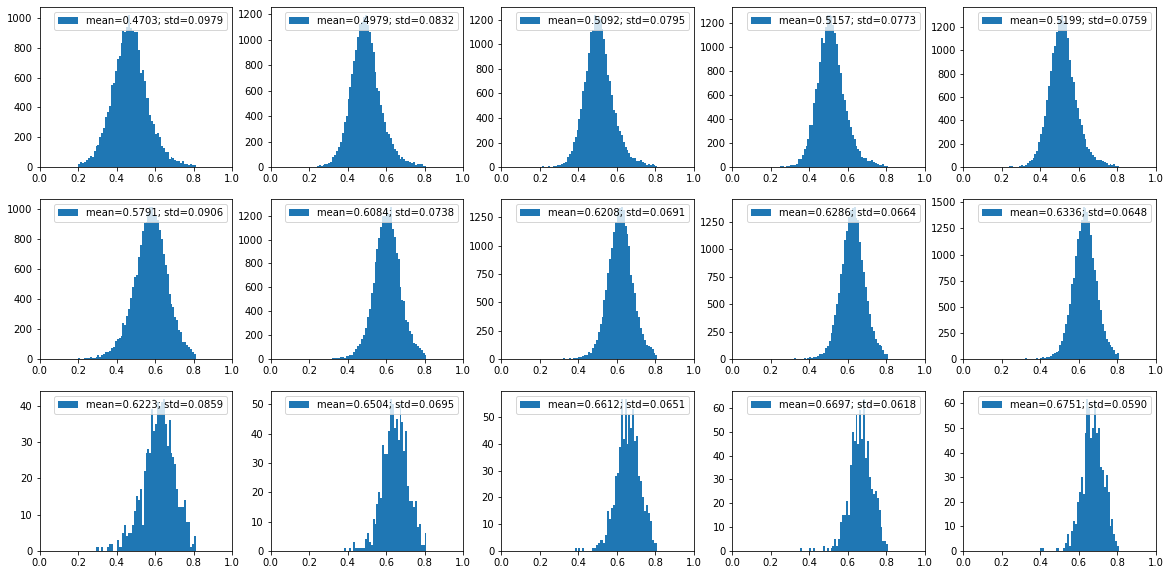

<IPython.core.display.Javascript object>

In [5]:
fig, ax = plt.subplots(3,5, figsize=(20,10))
for i,model in enumerate(models):
    p = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(p, "rb") as f:
        d = pickle.load(f)
        for j, v in enumerate(d[model]):
            x = []
            bins = np.arange(0.2, 0.81, 0.01)
            for k,t in v.items():
                if t[2]>0 and t[3]>0:
                    x.append(np.mean(t[0]))
            # root mean squared
            ax[i,j].hist(
                x,bins, label=f"mean={np.mean(x):.4f}; std={np.std(x):.4f}"
            )
            ax[i,j].set_xlim(0,1)
            ax[i,j].legend(loc="best")
plt.show()

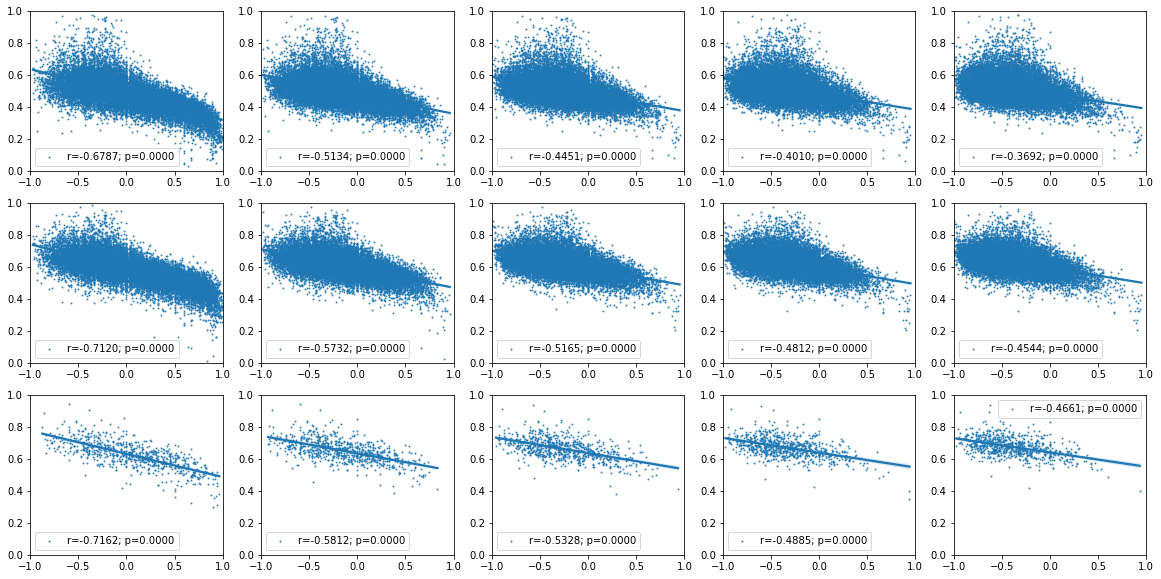

<IPython.core.display.Javascript object>

In [6]:
fig, ax = plt.subplots(3,5, figsize=(20,10))
rev_labels={0:"0%",1:"25%",2:"50%",3:"75%",4:"100%"}
for i,model in enumerate(models):
    p = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(p, "rb") as f:
        d = pickle.load(f)
        for j, v in enumerate(d[model]):
            y = []
            x = []
            for k,t in v.items():
                if t[2]>0 and t[3]>0:
                    y.append(np.mean(t[0]))
                    x.append((t[2]-t[3])/(t[2]+t[3]))
            r,p = pearsonr(x,y)
            sns.regplot(x=x,y=y,ax=ax[i,j],label=f"r={r:.4f}; p={p:.4f}",scatter_kws={'s':1})
            ax[i,j].set_ylim(0,1)
            ax[i,j].set_xlim(-1,1)
            ax[i,j].legend(loc="best")
plt.show()

### thresholds

In [10]:
thresholds = np.arange(0.6, 1, 0.01).tolist()
rev_labels={0:"  0%",1:" 25%",2:" 50%",3:" 75%",4:"100%"}
sentence_transformers_threshold_findings = {}
for model in models:
    print(f"##### {model} #####")
    print("\n")
    sentence_transformers_threshold_findings[model]=[{},{},{},{},{}]
    p = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(p, "rb") as f:
        d = pickle.load(f)
        biographies_amount = len(d[model][0])
        for threshold in thresholds:
            for time, v in enumerate(d[model]):
                findings_amount = 0
                for gnd,t in v.items():
                    # ndb <- wiki
                    if t[0] and max(t[0])>threshold:
                        findings_amount+=1
                print(f"({model=}; time={rev_labels[time]} revs; threshold={threshold:.2f}) biographies with min 1 sentence > threshold: {findings_amount}/{biographies_amount}")
                sentence_transformers_threshold_findings[model][time][f"{threshold:.2f}"]=findings_amount
            print("")
    print("\n")      

##### distiluse-base-multilingual-cased-v1 #####


(model='distiluse-base-multilingual-cased-v1'; time=  0% revs; threshold=0.60) biographies with min 1 sentence > threshold: 16525/20457
(model='distiluse-base-multilingual-cased-v1'; time= 25% revs; threshold=0.60) biographies with min 1 sentence > threshold: 18372/20457
(model='distiluse-base-multilingual-cased-v1'; time= 50% revs; threshold=0.60) biographies with min 1 sentence > threshold: 18832/20457
(model='distiluse-base-multilingual-cased-v1'; time= 75% revs; threshold=0.60) biographies with min 1 sentence > threshold: 19054/20457
(model='distiluse-base-multilingual-cased-v1'; time=100% revs; threshold=0.60) biographies with min 1 sentence > threshold: 19161/20457

(model='distiluse-base-multilingual-cased-v1'; time=  0% revs; threshold=0.61) biographies with min 1 sentence > threshold: 16064/20457
(model='distiluse-base-multilingual-cased-v1'; time= 25% revs; threshold=0.61) biographies with min 1 sentence > threshold: 17970/20

<IPython.core.display.Javascript object>

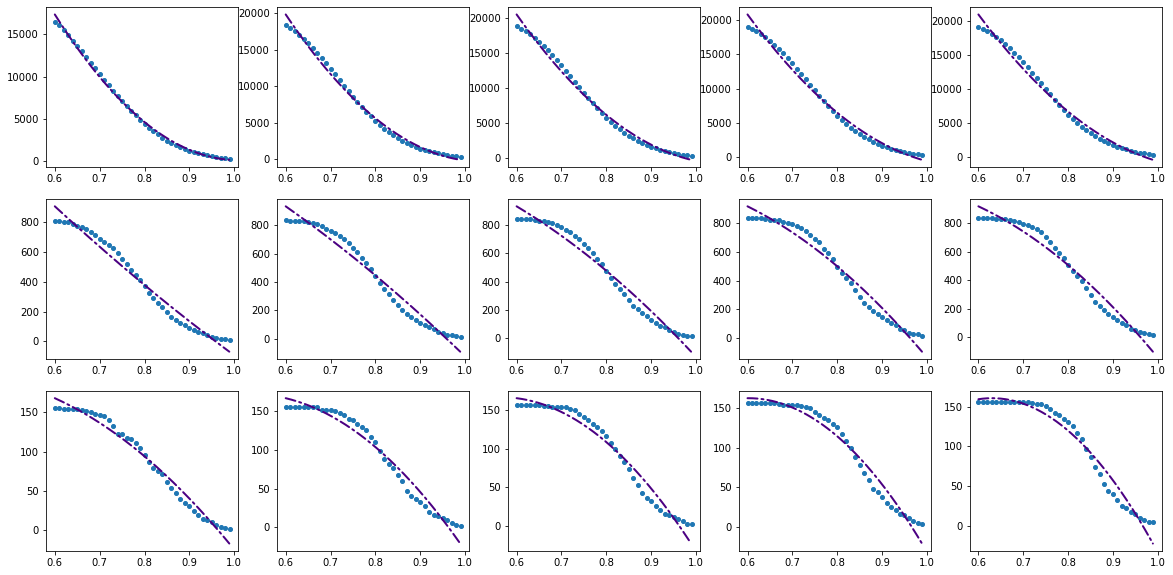

<IPython.core.display.Javascript object>

In [12]:
from scipy.optimize import curve_fit
#sentence_transformers_threshold_findings
# define the true objective function
def objective(x, a, b, c):
    return a * x + b * x**2 + c

fig, ax = plt.subplots(3,5, figsize=(20,10))


for i, (model,v) in enumerate(sentence_transformers_threshold_findings.items()):
    for j,val in enumerate(v):
        # curve fit
        x=[float(x) for x in [*val.keys()]]
        y=[int(x) for x in [*val.values()]]
        popt, _ = curve_fit(objective, x, y)
        a, b, c = popt
        #print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
        ax[i,j].scatter(x=x,y=y,s=16)
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 0.001)
        # calculate the output for the range
        y_line = objective(x_line, a, b, c)
        ax[i,j].plot(x_line, y_line, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round', color='#4b0082',linewidth=2)
        #ax[i,j].set_ylim(0,20457)
plt.show()

## wikipedia <- ndb

### mean

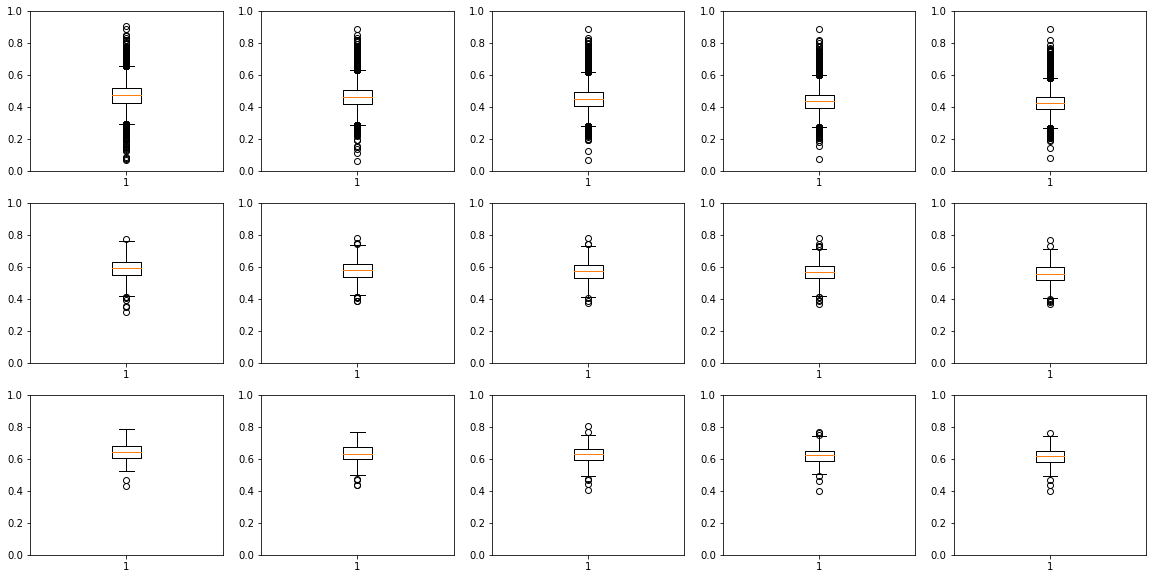

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(3, 5, figsize=(20,10))

for idx,model in enumerate(models):
    p = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(p, "rb") as f:
        d = pickle.load(f)
        for i, v in enumerate(d[model]):
            mean_vals = []
            for k,t in v.items():
                if t[1]:
                    mean_vals.append(np.mean(t[1]))
            ax[idx,i].boxplot(mean_vals)
            #ax[idx,i].axhline(y=np.median(mean_vals), color='orange',linewidth=1)
plt.setp(ax, ylim=(0,1))
plt.show()

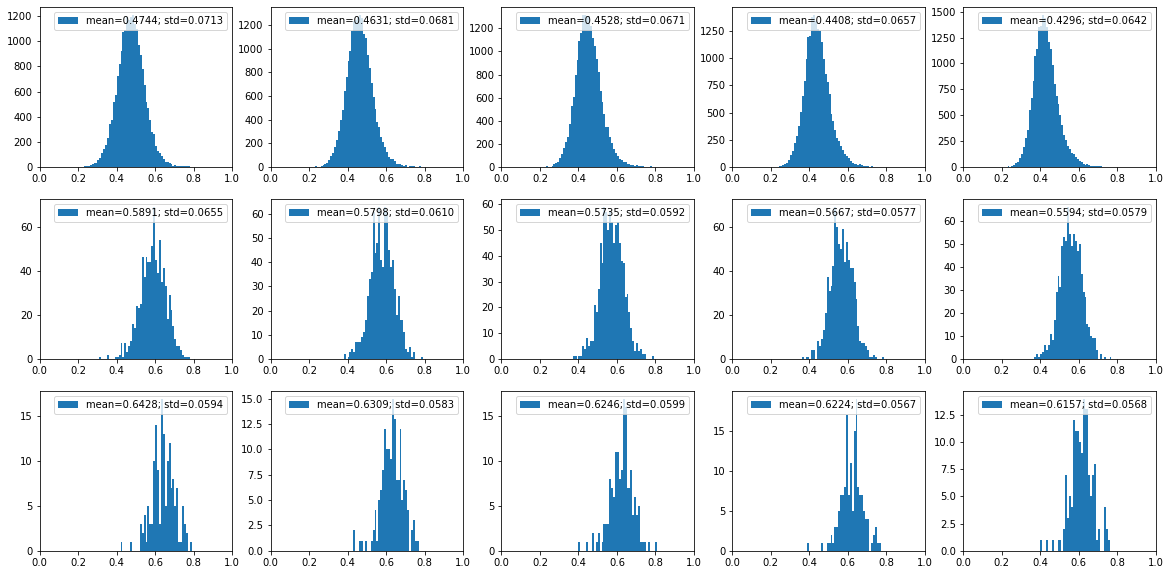

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(3,5, figsize=(20,10))
for i,model in enumerate(models):
    p = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(p, "rb") as f:
        d = pickle.load(f)
        for j, v in enumerate(d[model]):
            x = []
            bins = np.arange(0.2, 0.81, 0.01)
            for k,t in v.items():
                if t[2]>0 and t[3]>0:
                    x.append(np.mean(t[1]))
            # root mean squared
            ax[i,j].hist(
                x,bins, label=f"mean={np.mean(x):.4f}; std={np.std(x):.4f}"
            )
            ax[i,j].set_xlim(0,1)
            ax[i,j].legend(loc="best")
plt.show()

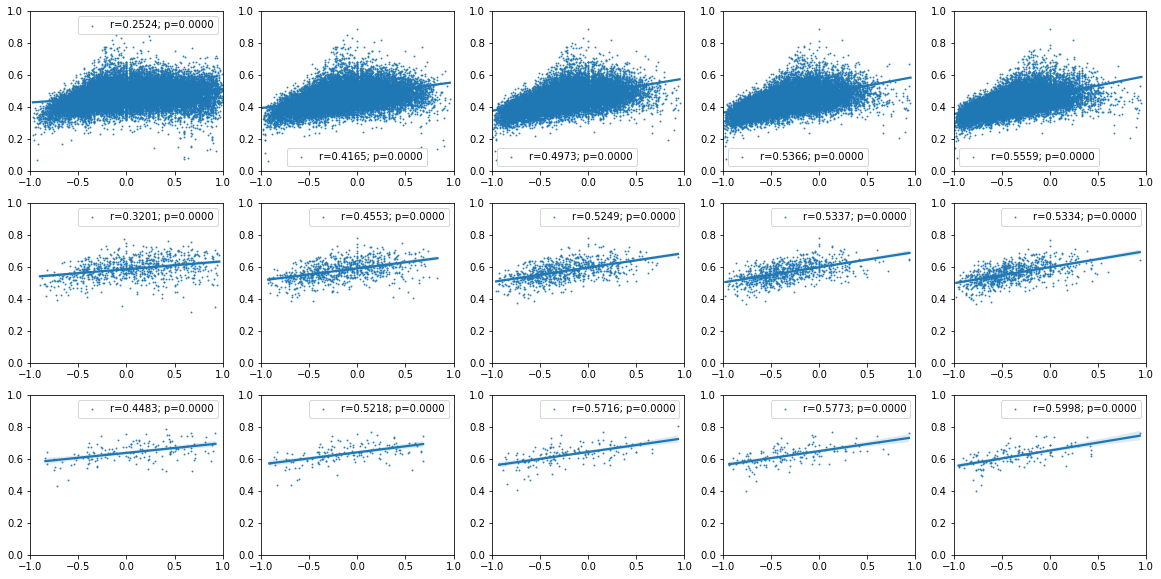

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(3,5, figsize=(20,10))
rev_labels={0:"0%",1:"25%",2:"50%",3:"75%",4:"100%"}
for i,model in enumerate(models):
    p = os.path.join(cwd, "data/reuse/models/", model+".pkl")
    with open(p, "rb") as f:
        d = pickle.load(f)
        for j, v in enumerate(d[model]):
            y = []
            x = []
            for k,t in v.items():
                if t[2]>0 and t[3]>0:
                    y.append(np.mean(t[1]))
                    x.append((t[2]-t[3])/(t[2]+t[3]))
            r,p = pearsonr(x,y)
            sns.regplot(x=x,y=y,ax=ax[i,j],label=f"r={r:.4f}; p={p:.4f}",scatter_kws={'s':1})
            ax[i,j].set_ylim(0,1)
            ax[i,j].set_xlim(-1,1)
            ax[i,j].legend(loc="best")
plt.show()

## thresholds

+ same as ndb <- wiki (since max is same)

### eval 

In [15]:
threshold = 0.85
model="distiluse-base-multilingual-cased-v1"
p = os.path.join(os.getcwd(), "data/reuse/models/distiluse-base-multilingual-cased-v1.pkl")
c = 0
with open(p, "rb") as f:
    d = pickle.load(f)
    biographies_amount = len(d[model][1])
    for time, v in enumerate(d[model]):
        for gnd,t in v.items():
            if t[0] and t[1]:
                max_ndb = round(max(t[0]),4)
                max_wiki = round(max(t[1]),4)
                if abs(max_ndb-max_wiki)>0.001:
                    print(f"{gnd=} {time=} {max_ndb=} {max_wiki=}")
                    c+=1
print(c)

0


<IPython.core.display.Javascript object>